In [2]:

from src.acoustic_analyser import frame
import numpy as np

test_frame = frame.from_file(member_file="test_member.json", constraint_file="test_constraint.csv")

free_end = test_frame.fixed_end(member_id=0)
free_end = test_frame.free_end(member_id=1)

matrix = test_frame.get_equation_matrix(w=0.1)

1
51
101
151
201
251
301
351


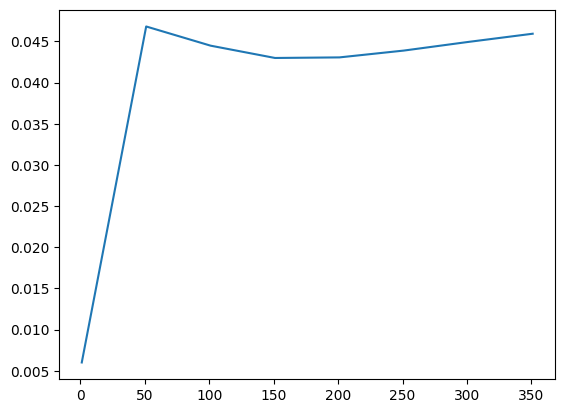

In [4]:
y = []
x = np.arange(1,400,50)
for freq in x:
    w = 2*np.pi*freq
    matrix = test_frame.get_equation_matrix(w=w)
    y.append(abs(np.linalg.det(matrix)))
    print(freq)

from matplotlib import pyplot as plt
plt.plot(x,y)

In [5]:
y

[0.006010276959415838,
 0.046807315671635465,
 0.04447698045997434,
 0.04298309653467666,
 0.043053093031539466,
 0.04388233881149884,
 0.04493074464289739,
 0.04592768376879455]